In [ ]:
# default_exp simulation
%load_ext autoreload
%autoreload 2

# Simulation
> Generate simulated cells

In [ ]:
#hide
from nbdev.showdoc import show_doc

In [ ]:
#export
import os
import numpy as np
import pandas as pd
import scipy
from scipy.stats import poisson
from light_curves.loglike import *

In [ ]:
#export
class Sampler():
    """ Sample an arbitrary function or histogram
    
    - func -- the function, or a histogram
    - a,b  -- limits (default 0,1)
    - n    -- table size (ignored if a histogram)
    
    Note the property `mean` is the expected mean.
    """
     
    def __init__(self, func, a=0, b=1, n=100):
        self.x = np.linspace(a,b,n+1) # bin edges
        dx = (b-a)/(n)/2

        if not hasattr(func, '__len__'):
            # evaluate at bin centers
            y = [func(t-dx) for t in self.x]
        else:
            n = len(func) 
            self.x = np.linspace(a,b,n)
            y = func
        cy = np.cumsum(y)
        d = cy[-1]-cy[0]
        self.sy = (cy-cy[0])/d
        
        self.mean = np.sum( (self.x-dx) * y) / d

    def _evaluate(self, r):
        """evaluate inverse integral. expect 0<r<1 """
        return np.interp(r, self.sy, self.x)
    
    def __call__(self, size):
        """Generate `size` values
        """
        from scipy.stats import uniform
        return self._evaluate(uniform.rvs(size=size))

In [ ]:
#hide
show_doc(Sampler)
show_doc(Sampler.__call__)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`func`**, **`a`**=*`0`*, **`b`**=*`1`*, **`n`**=*`100`*)

Sample an arbitrary function or histogram

- func -- the function, or a histogram
- a,b  -- limits (default 0,1)
- n    -- table size (ignored if a histogram)

Note the property `mean` is the expected mean.

<h4 id="Sampler.__call__" class="doc_header"><code>Sampler.__call__</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>Sampler.__call__</code>(**`size`**)

Generate `size` values
        

###  Tests:  Gaussian and quadratic


In [ ]:
n = 20
sf = Sampler(lambda x: np.exp(-(x**2)/2), -4, 4, n)

data = sf(10000)
tests = np.array([np.abs(data.mean()), np.abs(data.std()-1) ])
assert np.all(tests<5e-2 ), f'Failed Tests: mean {data.mean()}, std {data.std()}'

func = lambda x: x**2
wfun = Sampler(func, 0,1)

test2 = wfun.mean,  np.mean(wfun(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

In [ ]:
#export
class WeightGenerator(Sampler):
    """Generate a set of weights
    
    - `func` -- nominal weight distribution function, evaluated on (0,1)
    - `alpha, beta` -- (default 0,0). Values for $\\alpha$, $\\beta$.
    
    """
    def __init__(self, func, alpha=0, beta=0, n=100):
        if alpha==0 and beta==0:
            fprime = func
        else:
            # weight the function
            fprime = lambda w: func(w) * ( 1 + alpha*w + beta*(1-w) )
        super().__init__( fprime, a=0, b=1, n=n)
  

In [ ]:
#hide
show_doc(WeightGenerator)

<h2 id="WeightGenerator" class="doc_header"><code>class</code> <code>WeightGenerator</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>WeightGenerator</code>(**`func`**, **`alpha`**=*`0`*, **`beta`**=*`0`*, **`n`**=*`100`*) :: [`Sampler`](/light_curves/simulation.html#Sampler)

Generate a set of weights

- `func` -- nominal weight distribution function, evaluated on (0,1)
- `alpha, beta` -- (default 0,0). Values for $\alpha$, $\beta$.

In [ ]:
      
wg = WeightGenerator(func, 0, 1)
test2 = wg.mean,  np.mean(wg(1000))
assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'
test2

(0.7199871931569316, 0.7229479245367344)

In [ ]:
#export
def generate_cell(wfun, mu, alpha=0, beta=0):
    """ Generate a cell

    - `wfun` -- weight function, or histogram. 
        Defined on (0,1)
    - `mu` -- number of expected weights, on average
    - `alpha`, `beta`  -- default 0,0; values for $\\alpha$ and  $\\beta$ for this cell 
    
    Returns a dict with:
    - `n` -- actual generated number of weights, from Poisson 
    - `w` -- array of weights * 256, as  uint8 integers
    - `S, B` -- expected values for $\sum w$ and $\sum(1-w)$, calulated from wfun
    """

    wgen_nominal = WeightGenerator(wfun)
    wgen_cell =wgen_nominal if alpha==0 and beta==0 else WeightGenerator(wfun, alpha, beta)
    
    # adjust expected number of events:
    wbar = wgen_nominal.mean
    mu_cell = mu * (1+alpha*wbar+beta*(1-wbar))
   
    # the weight array
    n = poisson.rvs(mu_cell )    
    w = wgen_cell(n)
    
    S = wgen_nominal.mean * mu
    B = mu-S
    
    return dict(
        n=n,
        w=np.array(w*256, np.uint8),
        S=S,
        B=B,
    )

In [ ]:
#hide
show_doc(generate_cell)

<h4 id="generate_cell" class="doc_header"><code>generate_cell</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>generate_cell</code>(**`wfun`**, **`mu`**, **`alpha`**=*`0`*, **`beta`**=*`0`*)

Generate a cell

- `wfun` -- weight function, or histogram. 
    Defined on (0,1)
- `mu` -- number of expected weights, on average
- `alpha`, `beta`  -- default 0,0; values for $\alpha$ and  $\beta$ for this cell 

Returns a dict with:
- `n` -- actual generated number of weights, from Poisson 
- `w` -- array of weights * 256, as  uint8 integers
- `S, B` -- expected values for $\sum w$ and $\sum(1-w)$, calulated from wfun

Test with a function peaked at both ends, generate equal signal and background

In [ ]:
#
#collapse_hide
def test_gen(alpha, beta, mu=10000, tol=3, quiet=True):
    wfun = lambda x: (x-0.5)**2
    pd.set_option('display.precision', 3)
    if not quiet: print(f'Test with alpha={alpha}, beta={beta}')
    cell = generate_cell( wfun, mu,  alpha, 0 if beta is None else beta)
    #
    ll = LogLike(cell); 
    if not quiet: print(f'Generated cell info:\n{ ll}')

    fit = ll.fit_info(beta is None )
    if not quiet: print(f'{2 if beta is not None else 1}-D fit info:\n{pd.Series(fit)}')
    t, sigt = fit['flux']-(1+alpha),  fit['sig_flux']
    check_alpha = '' if  np.abs(t)<tol*sigt else f'alpha: abs({t:.3f}) > {tol} * {sigt:.3f}'

    if beta is None:
        assert not bool(check_alpha), f'Failed: {check_alpha} '
    else:
        t, sigt = fit['beta']-beta, fit['sig_beta']
        check_beta ='' if np.abs(t)<tol*sigt else f'beta: abs({t:.3f}) > {tol} * {sigt:.3f}'

        assert not ( bool(check_alpha)  or bool(check_beta)), f'{check_alpha}  {check_beta}'
test_gen(0,None)
test_gen(10,None)
#test_gen(10, 0, tol=5, quiet=False)
test_gen(0,2)
test_gen(0.1, None, quiet=False)

Test with alpha=0.1, beta=None
Generated cell info:
light_curves.loglike.LogLike:  10386 weights, S 4998.5, B 5001.5
1-D fit info:
counts      10386.000
flux            1.101
sig_flux        0.016
dtype: float64


## Generate a set of poisson-like fits to the likelihoods

In [ ]:
#hide
wfun = lambda x: (x-0.5)**2
mu = 100
alpha = 0.1
pfits  = [PoissonRep(LogLike(generate_cell( wfun, mu ,alpha))) for i in range(1000)]

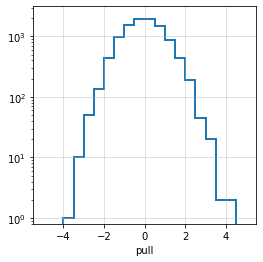

In [ ]:
fig,ax = plt.subplots(figsize=(4,4))
flux = np.array([pfit.flux for pfit in pfits])
ax.hist((flux-1-alpha)/flux.std() , np.linspace(-5, 5, 21), lw=2, histtype='step', log=True);
ax.set(ylim=(0.8,None), xlabel='pull'); ax.grid(alpha=0.5)

Compare observed std with means

In [ ]:
uppers = np.array([p.errors[1]-p.flux for p in pfits])
lowers = np.array([p.flux - p.errors[0] for p in pfits])

In [ ]:
print(f'mean errors: {(np.mean(uppers)+ np.mean(lowers))/2:.3f}, STD: {flux.std():.3f} ')

mean errors: 0.164, STD: 0.167 


In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date